In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
workers = 8
ngpu = 1
beta1 = 0.5
lr = 0.0002
bs = 60
epochs = 60

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 12, kernel_size = 5, padding = 2)
        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        xb = torch.sigmoid(self.conv(xb))       
        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x, b_y))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess)
valid_dl = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.6147919774055481
1 0.5205105423927308
2 0.4585020661354065
3 0.42425220012664794
4 0.40438591241836547
5 0.3915667474269867
6 0.3824493169784546
7 0.37547152638435366
8 0.369846910238266
9 0.36514397859573366
10 0.3611059427261353
11 0.35756872296333314
12 0.3544214367866516
13 0.3515856623649597
14 0.3490038812160492
15 0.3466327726840973
16 0.3444388687610626
17 0.3423958599567413
18 0.3404826819896698
19 0.33868226408958435
20 0.3369806170463562
21 0.3353660643100739
22 0.3338288187980652
23 0.3323606014251709
24 0.3309544205665588
25 0.3296042025089264
26 0.328304648399353
27 0.3270512640476227
28 0.32584004998207095
29 0.32466751933097837
30 0.3235305309295654
31 0.3224264085292816
32 0.3213525950908661
33 0.3203070402145386
34 0.3192876160144806
35 0.3182927489280701
36 0.31732070446014404
37 0.3163700759410858
38 0.31543956995010375
39 0.31452795267105105
40 0.313634192943573
41 0.3127572417259216
42 0.3118962347507477
43 0.3110503196716309
44 0.3102186739444733
45 0.3094006

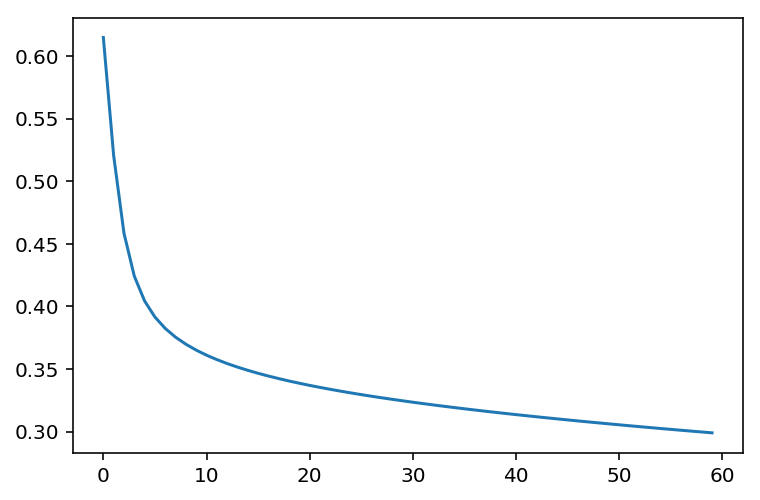

In [14]:
plt.plot(val_losses)
plt.show()

In [15]:
torch.save(model, "SR_model_2.1.ml")

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SuperResolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>